In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # much faster than svg when generating lots of points
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.anova as sa
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# set print precision
np.set_printoptions(precision=5, suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [23]:
# load train data to build model
df = pd.read_csv('data/train.csv')
df.head()
df.dtypes

category                 object
rating                  float64
reviews                 float64
installs                float64
type                     object
price                   float64
content_rating           object
app_size                float64
last_updated_encoded      int64
dtype: object

# Data Exploration
* Categorical, bar charts - Amee 
* Histograms - Flora
* Scatter plots matrix of all numeric variables - Sandy
* Correlation analysis for numeric variables (heatmap)  - Sandy 


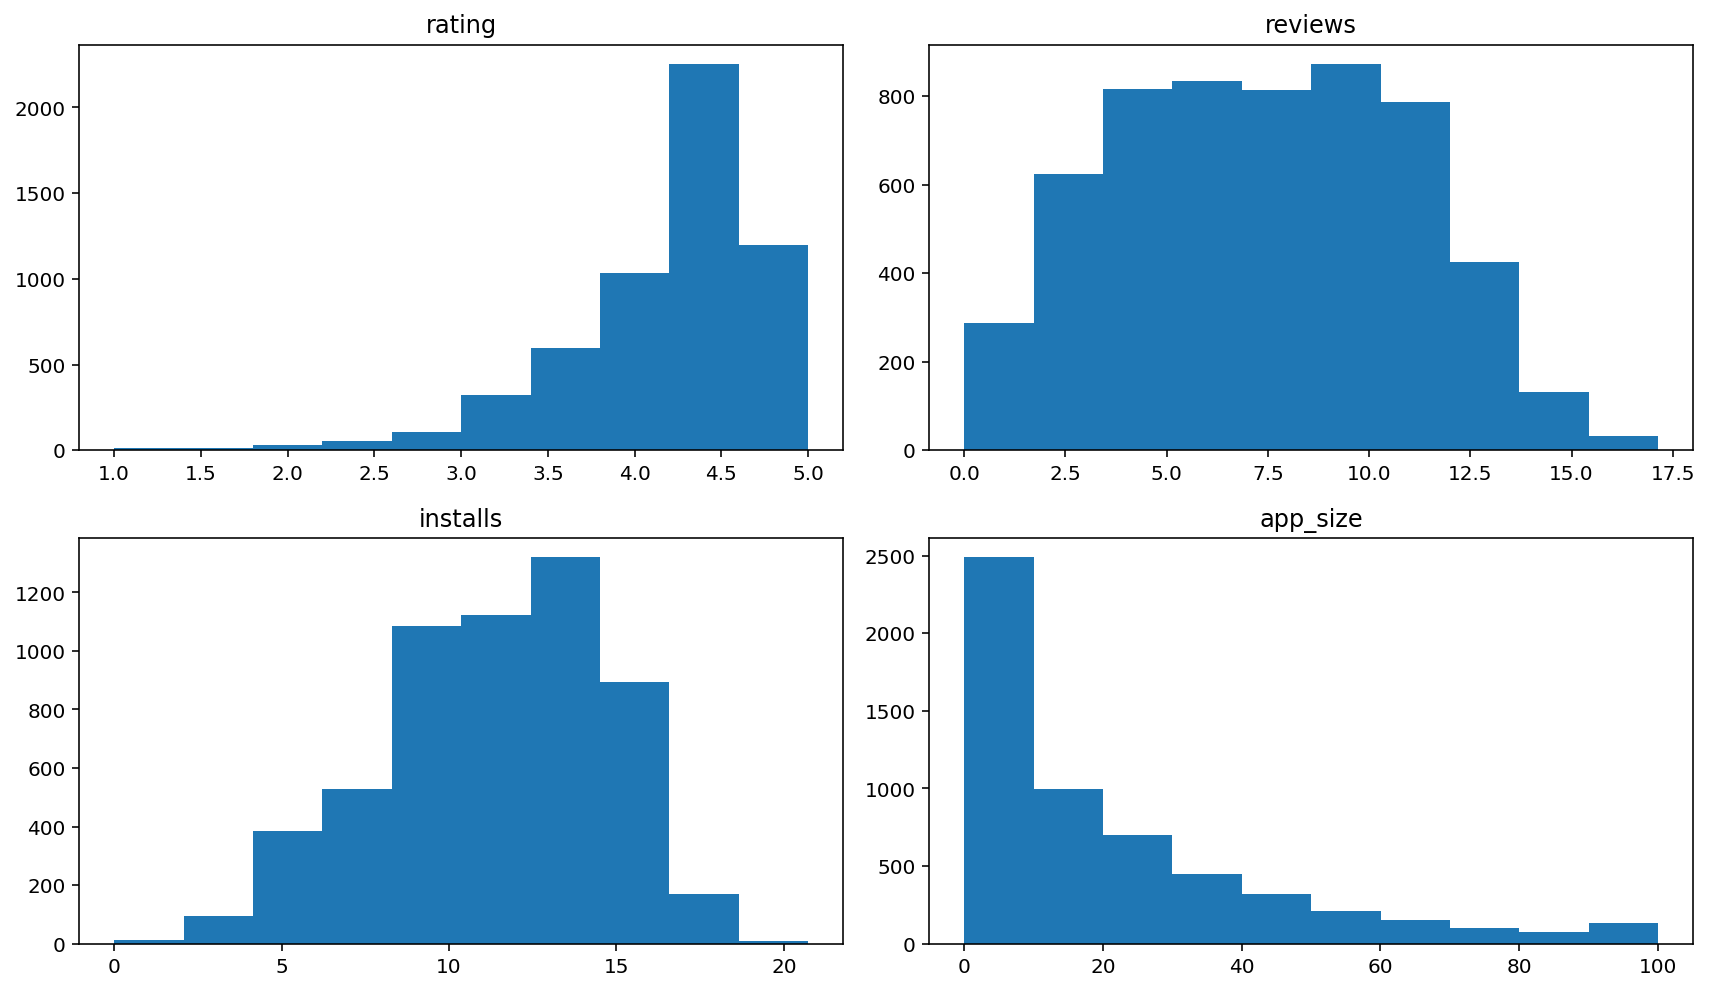

In [16]:
# numeric variables
numeric_vars = df.select_dtypes(np.number)

fig, axes = plt.subplots(nrows=2, ncols=int(len(numeric_vars.columns)/2), figsize = (12,7), )
axes = np.array(axes).flatten()

for i, ax in enumerate(axes):
    ax.hist(numeric_vars.iloc[:, i])
    ax.set_title(numeric_vars.columns[i])
    
plt.tight_layout()
plt.show()

### It appears that reviews, installs, price have large range, obscuring the direct histogram view

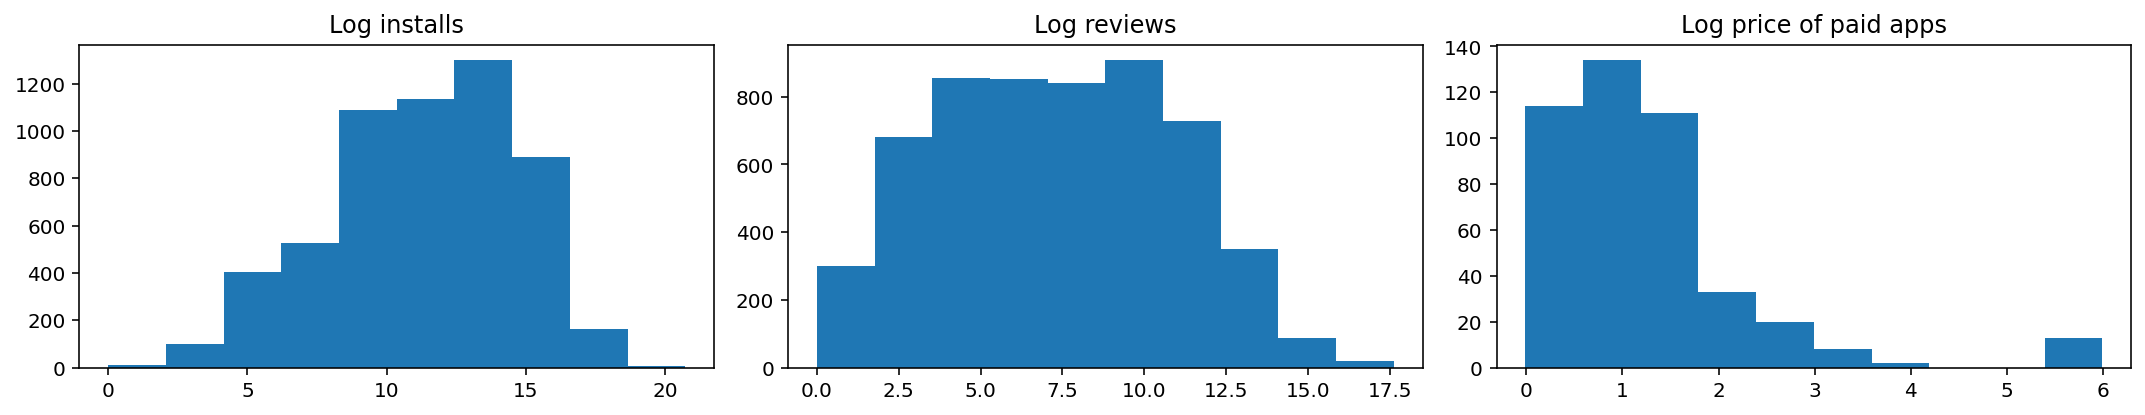

In [9]:
# get numeric variables with large range
numeric_large_range = numeric_vars[['installs','reviews','price']]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,3))
axes = np.array(axes).flatten()

# apply log transformation on large range numeric variables
for i, ax in enumerate(axes):
    if i < 2:
        ax.hist(np.log(numeric_large_range.iloc[:, i]))
        ax.set_title('Log ' + numeric_large_range.columns[i])
    else:
        # for price, since log 0 = inf, only show paid apps
        ax.hist(np.log(numeric_large_range.iloc[:, i][numeric_large_range.price > 0]))
        ax.set_title('Log ' + numeric_large_range.columns[i] + ' of paid apps')

plt.tight_layout()
plt.show()


# Initial model fit with all variables

In [24]:
# regress rating against all other variables
ystr = 'rating'
x_var = [col for col in df.columns if col != ystr]
xstr = '+'.join(x_var)

# build initial ols model 
model = smf.ols(f'{ystr}~{xstr}', data=df).fit()

# drop a variable in model 
x_var2 = x_var.copy()
x_var2.remove(set(x_var2).pop())
xstr_drop = '+'.join(x_var2)
model_drop = smf.ols(f'{ystr}~{xstr_drop}', data=df).fit()

print(model.summary())
# print(model_drop.summary())


                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     55.84
Date:                Fri, 27 Nov 2020   Prob (F-statistic):          2.83e-147
Time:                        16:09:16   Log-Likelihood:                -4344.3
No. Observations:                5623   AIC:                             8719.
Df Residuals:                    5608   BIC:                             8818.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

# ANOVA

In [19]:
partial = sa.anova_lm(model, type=2)
partial_drop = sa.anova_lm(model_drop, type=2)
seq = sa.anova_lm(model, type=1)
seq_drop = sa.anova_lm(model_drop, type=1)

print('~~~~~~~ Partial ANOVA ~~~~~~~')
print(partial)

print('\n~~~~~~~ Partial ANOVA w/ one dropped variable~~~~~~~')
print(partial_drop)

# print('\n~~~~~~~ Sequential ANOVA ~~~~~~~')
# print(seq)

# print('\n~~~~~~~ Sequential ANOVA w/ one dropped variable ~~~~~~~')
# print(seq_drop)


~~~~~~~ Partial ANOVA ~~~~~~~
                             df     sum_sq   mean_sq         F  PR(>F)
category                4.00000    6.68773   1.67193   6.06488 0.00007
type                    1.00000    2.58975   2.58975   9.39423 0.00219
content_rating          4.00000    4.67939   1.16985   4.24358 0.00198
reviews                 1.00000   42.55950  42.55950 154.38314 0.00000
installs                1.00000  133.56221 133.56221 484.49237 0.00000
app_size                1.00000    0.75949   0.75949   2.75502 0.09701
last_updated_encoded    1.00000   21.78289  21.78289  79.01670 0.00000
Residual             5609.00000 1546.25852   0.27567       nan     nan

~~~~~~~ Partial ANOVA w/ one dropped variable~~~~~~~
                             df     sum_sq   mean_sq         F  PR(>F)
category                4.00000    6.68773   1.67193   6.06245 0.00007
type                    1.00000    2.58975   2.58975   9.39047 0.00219
reviews                 1.00000   44.78929  44.78929 162.40657 0

## Multicolinearity

In [9]:
numeric_x_var = df[x_var].select_dtypes(np.number)
X = sm.add_constant(numeric_x_var)
vif = pd.DataFrame([variance_inflation_factor(X.values, i) \
                    for i in range(X.shape[1])], 
                   index=['intercept'] + list(X.columns[1:].str.lower()),
                   columns=['vif'])
print(vif)

                          vif
intercept            91.34459
rating                1.02406
reviews               1.59009
installs              1.56284
app_size              1.08543
last_updated_encoded  1.07159


# Best subsets adhj-R, Cp, AIC/BIC

In [10]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def dummy2cat(vars):
    output = []
    cat = 0
    type_var = 0
    content = 0
    for var in vars:
        if any([cat_var in var for cat_var in ['category','content_rating', 'type']]):
            if cat == 0:
                output.append('category')
                cat = 1
            elif type_var == 0:
                output.append('type')
                type_var = 1
            elif content == 0:
                output.append('content')
                content = 1
        else:
            output.append(var)
    return var
            
subsets = list(powerset(x_var))[1:]
subsets_ols = [f"{ystr}~{'+'.join(sub)}" for sub in subsets]
models = [smf.ols(sub, data=df).fit() for sub in subsets_ols]


full_mse = models[-1].mse_resid
mallow = lambda reduced:  np.sum(np.power(reduced.resid, 2)) / full_mse - (len(df) - 2*len(reduced.params))
stat = [np.array([model.rsquared_adj, mallow(model)])for model in models]

In [11]:
rcp = []
# print(f'{"Vars":<4}  {"Predictors":<100}{"Adjusted R-sqr":>15}{"Mallows Cp":>15}')
for i, (r, mcp) in enumerate(stat):
#     print(f'{len(models[i].params)-1:>4}  {", ".join(subsets[i]):<100}{r:>15.3f}{mcp:>15.3f}')

    var_nums = len(models[i].params)-1
    predictors = ", ".join(subsets[i])
    rcp.append([var_nums, predictors, r, mcp])

rcp_df = pd.DataFrame(data=rcp, columns=['Vars', 'Predictors','Adjusted R-sqr', 'Mallow Cp'])

rcp_df.sort_values(by=['Adjusted R-sqr','Mallow Cp'], ascending=False).head(10)

,Vars,Predictors,Adjusted R-sqr,Mallow Cp
180,36,"category, rating, type, app_size, last_updated...",0.06287,31.27063
226,37,"category, rating, reviews, type, app_size, las...",0.06279,32.76892
230,37,"category, rating, installs, type, app_size, la...",0.06276,32.93388
248,38,"category, rating, reviews, installs, type, app...",0.06263,34.72675
125,35,"category, type, app_size, last_updated_encoded",0.06242,32.92634
190,36,"category, reviews, type, app_size, last_update...",0.06232,34.55848
194,36,"category, installs, type, app_size, last_updat...",0.06230,34.66579
235,37,"category, reviews, installs, type, app_size, l...",0.06216,36.52158
232,41,"category, rating, type, content_rating, app_si...",0.06215,40.58106
250,42,"category, rating, reviews, type, content_ratin...",0.06207,42.03302


# test removed influential points, log transform on  large range numerical data

In [40]:
# ic_vals = [(model.aic, model.bic) for model in models[-3:]]

# print()
# print(f'{"Predictors":<20}{"AIC":>15}{"BIC":>15}')
# for i, (aic, bic) in enumerate(ic_vals):
#     print(f'{", ".join(models[-3+i].params.index.values[1:]):<20}{aic:>15.3f}{bic:>15.3f}')

In [ ]:

import statsmodels.api as sm
import statsmodels.formula.api as smf

sm.qqplot(model.resid)